# CLAMPS Lidar VAD Tutorial

This tutorial will show you how to work with PPI data from the Halo Photonics Streamline lidars with the CLAMPS systems at OU and NSSL.

## Getting Data
CLAMPS data is stored on a THREDDS server (https://data.nssl.noaa.gov/thredds/catalog/FRDD/CLAMPS/catalog.html). We are going to use Siphon to grab the data from the server. If you use Anaconda, Siphon can be download by running
```
conda install -c conda-forge siphon
```
on the command line. If you use pip the command would be
```
pip install siphon
```

## Wind Profiles from VADs
Velocity Azimuth Display (VADs) are one of the most common scan types from the lidars that you will likely be working with. A VAD scan is performed at a constant elevation angle while scanning at different points in azimuth (sort of like a radar). From these VADs you can obtain low-level wind profiles by performing a VAD analysis. If the environment is homogeneous and the wind is constant during the scanning time, the radial velocities from a VAD will fit a sine wave. From this sine wave fit, the u, v, and w wind components can be determined.

We are going to work with VAD scans from the CLAMPS 2 lidar during the BLISS-FUL campaign on June 20, 2021. Let's first get the data:

In [1]:
from siphon.catalog import TDSCatalog
from datetime import datetime
import numpy as np

# Catalog for the CLAMPS2 ingested VAD data
catURL = "https://data.nssl.noaa.gov/thredds/catalog/FRDD/CLAMPS/clamps/clamps2/ingested/clampsdlppiC2.b1/catalog.xml"

# Open the catalog
cat = TDSCatalog(catURL)

# Date we want to grab
dt = datetime(2021, 6, 20)

# Get the dates for all the netCDF datasets (have to do it this way because file names can be messed up)
nc_dates = []
for ds in cat.datasets:
    if '.cdf' in ds:
        try:
            nc_dates.append(datetime.strptime(ds, "clampsdlppiC2.b1.%Y%m%d.%H%M%S.cdf"))
        except:
            nc_dates.append(datetime(2100,1,1))
            print('This file name is messed up: ' + ds)

nc_dates = np.array(nc_dates)

# Find the index of the date we want
ind = np.argmin(np.abs(dt - nc_dates))

# Get the dataset
ds = cat.datasets[ind]

# Download the dataset we identified to our current working directory
ds.download()


This file name is messed up: clampsdlppiC2.b1.20180303.000160.cdf
This file name is messed up: clampsdlppiC2.b1.20190325.000160.cdf
This file name is messed up: clampsdlppiC2.b1.20200823.010630.cdf_bck
This file name is messed up: clampsdlppiC2.b1.20200824.010803.cdf_bck


The data is now downloaded to your working directory. It is a netCDF file so we are going to open it with the netCDF4 package and look at the variables in the netCDF file

In [2]:
from netCDF4 import Dataset

nc = Dataset(ds,'r')

print(nc.variables)

{'base_time': <class 'netCDF4._netCDF4.Variable'>
int32 base_time()
    long_name: Time
    units: seconds since 1970-01-01 00:00:00 UTC
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used, 'time_offset': <class 'netCDF4._netCDF4.Variable'>
float64 time_offset(time)
    long_name: Time offset
    units: seconds since base_time
unlimited dimensions: time
current shape = (17200,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'hour': <class 'netCDF4._netCDF4.Variable'>
float64 hour(time)
    long_name: Hour of Day
    units: UTC
unlimited dimensions: time
current shape = (17200,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'range': <class 'netCDF4._netCDF4.Variable'>
float32 range(range)
    long_name: range
    units: km
unlimited dimensions: 
current shape = (666,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'azimuth': <class 'netCDF4._netCDF4.Variable'>
float32 azimuth(time)
    long_name: Azim

We want to read in the hour, azimuth, elevation, scan number, velocity, intensity, and range variables. 

In [3]:
hour = nc.variables['hour'][:]
azimuth = nc.variables['azimuth'][:]
elevation = nc.variables['elevation'][:]
snum = nc.variables['snum'][:]
velocity = nc.variables['velocity'][:]
intensity = nc.variables['intensity'][:]
rng = nc.variables['range'][:]
nc.close()

The data is not currently separated by scan. We need to use the scan number field to find the unique scans and seperate them so we can do the VAD calculations.

In [4]:
# np.unique returns sorted indices. We don't want that, so we are going 
# to only use the return_index option and make an unsorted unique array
indexes = np.unique(snum, return_index=True)[1]
u_snum = [snum[index] for index in sorted(indexes)]


Let's plot the radial velocity by azimuth for a scan random scan at a range of 500 m.

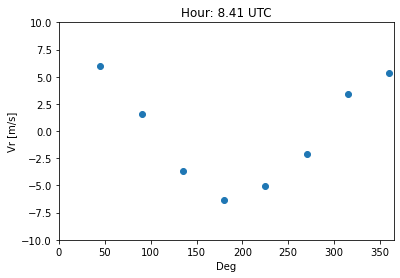

In [5]:
import matplotlib.pyplot as plt
# Picking a random scan
foo = np.where(u_snum[750] == snum)

# Now find the range closest to 500 m
fah = np.where(np.nanmin(np.abs(rng-0.5)) == np.abs(rng-0.5))

plt.figure()
plt.scatter(azimuth[foo],velocity[foo[0],fah[0]])
plt.xlim(0,365)
plt.ylim(-10,10)
plt.ylabel('Vr [m/s]')
plt.xlabel('Deg')
plt.title('Hour: %2.2f UTC' % (np.nanmean(hour[foo[0]])))
plt.show()


You can see here how the radial velocity at each azimuth in the VAD has a sine/cosine wave shape. The amplitude of the wave is related to the wind speed, the phase of the wave is related to the wind direction and the offset from zero is related to the vertical velocity. Note how the radial velocities do not form a perfect wave, this can be due to things like measurement error or a heterogeneous environment. The above plot is for a scan that occurred at night when the environment is often more homogeneous. Let's look at what this plot looks like in the daytime.

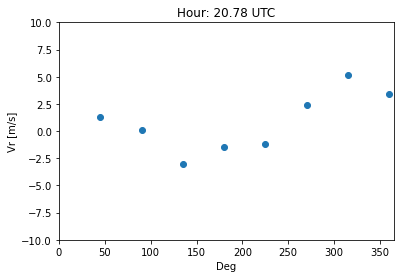

In [6]:
# Picking a random scan
foo = np.where(u_snum[1862] == snum)

# Now find the range closest to 500 m
fah = np.where(np.nanmin(np.abs(rng-0.5)) == np.abs(rng-0.5))

plt.figure()
plt.scatter(azimuth[foo],velocity[foo[0],fah[0]])
plt.xlim(0,365)
plt.ylim(-10,10)
plt.ylabel('Vr [m/s]')
plt.xlabel('Deg')
plt.title('Hour: %2.2f UTC' % (np.nanmean(hour[foo[0]])))
plt.show()

For this scan, the wave is more distorted so a VAD analysis is going to be less accurate. Most of the time, VAD analysis is going more accurate in stable boundary layers than convective boundary layers.

Now we are going to calculate VAD winds for the entire file. A discription of the function that we are going to use can be found [here](https://doi.org/10.2172/1238069). This is a least-squares based approach where we are minimizing the error between the retrieved wind projected into radial velocity space and the observed radial velocities.

In [7]:
def ARM_VAD(vr,ranges,el,az):
    
    # Need these x, y, and z distances for calculating the residuals
    x = ranges[None,:]*np.cos(np.radians(el))*np.sin(np.radians(az[:,None]))
    y = ranges[None,:]*np.cos(np.radians(el))*np.cos(np.radians(az[:,None]))
    z = ranges*np.sin(np.radians(el))
    
    
    # Initialize the arrays
    u = np.ones(len(ranges))*np.nan
    v = np.ones(len(ranges))*np.nan
    w = np.ones(len(ranges))*np.nan
    du = np.ones(len(ranges))*np.nan
    dv = np.ones(len(ranges))*np.nan
    dw = np.ones(len(ranges))*np.nan
    
    # Loop over all the ranges
    for i in range(len(ranges)):
        # Search for missing data
        foo = np.where(~np.isnan(vr[:,i]))[0]

        # Need at least 25% of the azimuth radial velocities available for retrieval
        if len(foo) <= len(az)/4:
            u[i] = np.nan
            v[i] = np.nan
            w[i] = np.nan
            continue

        # Calculate the different portions of the A matrix
        A11 = (np.cos(np.deg2rad(el))**2) * np.sum(np.sin(np.deg2rad(az[foo]))**2)
        A12 = (np.cos(np.deg2rad(el))**2) * np.sum(np.sin(np.deg2rad(az[foo])) *\
                np.cos(np.deg2rad(az[foo])))
        A13 = (np.cos(np.deg2rad(el))*np.sin(np.deg2rad(el))) *\
                np.sum(np.sin(np.deg2rad(az[foo])))
        A22 = (np.cos(np.deg2rad(el))**2) * np.sum(np.cos(np.deg2rad(az[foo]))**2)
        A23 = (np.cos(np.deg2rad(el))*np.sin(np.deg2rad(el))) *\
                np.sum(np.cos(np.deg2rad(az[foo])))
        A33 = len(az[foo]) * (np.sin(np.deg2rad(el))**2)

        # Construct the A matrix
        A = np.array([[A11,A12,A13],[A12,A22,A23],[A13,A23,A33]])
        
        # Invert the A matrix
        invA = np.linalg.inv(A)
    
        # The digagonals of invA give the uncertainties for each wind component
        du[i] = np.sqrt(invA[0,0])
        dv[i] = np.sqrt(invA[1,1])
        dw[i] = np.sqrt(invA[2,2])
    
        # Calculate the different portions of the b vector
        b1 = np.cos(np.deg2rad(el)) * np.sum(vr[foo,i] *\
            np.sin(np.deg2rad(az[foo])))
        b2 = np.cos(np.deg2rad(el)) * np.sum(vr[foo,i] *\
            np.cos(np.deg2rad(az[foo])))
        b3 = np.sin(np.deg2rad(el)) * np.sum(vr[foo,i])
    
        # Constuct the b vector
        b = np.array([b1,b2,b3])
    
        # Do the matrix math
        temp = invA.dot(b)
        u[i] = temp[0]
        v[i] = temp[1]
        w[i] = temp[2]
    
    # Calculate wind speed and direction
    speed = np.sqrt(u**2 + v**2)
    wdir = 270 - np.rad2deg(np.arctan2(v,u))

    # Make sure wind directions are not greater than 360 degrees
    wdir = np.where(wdir >= 360, wdir-360, wdir)

    # Calculate the residual of the retrieval solution
    residual = (np.sqrt(np.nanmean(((((u*x)+(v*y)+((w*z))[None,:])\
                /np.sqrt(x**2+y**2+z**2))-vr)**2,axis = 0)))
    
    return u,v,w,speed,wdir,du,dv,dw,residual

We are going to loop over each scan in the VAD file. Before passing the data to the VAD fucntion, we are going to filter out gates that are below an intensity threshold.

In [11]:
foo = np.where(intensity < 1.006)
velocity[foo] = np.nan

# Initialize the arrays for the retrieval
u = np.ones((len(u_snum),len(rng)))*np.nan
v = np.ones((len(u_snum),len(rng)))*np.nan
w = np.ones((len(u_snum),len(rng)))*np.nan
du = np.ones((len(u_snum),len(rng)))*np.nan
dv = np.ones((len(u_snum),len(rng)))*np.nan
dw = np.ones((len(u_snum),len(rng)))*np.nan
speed = np.ones((len(u_snum),len(rng)))*np.nan
wdir = np.ones((len(u_snum),len(rng)))*np.nan
residual = np.ones((len(u_snum),len(rng)))*np.nan

time = np.ones(len(u_snum))*np.nan
count = 0
# This is the loop that loops over each scan
for i in range(len(u_snum)):
    foo = np.where(u_snum[i] == snum)[0]
    
    time[i] = np.nanmean(hour[foo])
    
    # Just a counter to prove that it is working
    if int(time[i]) >= count:
        print('Processing scan at ' + str(time[i]))
        count += 1
        
    u[i], v[i], w[i], speed[i], wdir[i],\
    du[i], dv[i], dw[i], residual[i] = ARM_VAD(velocity[foo,:], rng, elevation[foo][0], azimuth[foo])

Processing scan at 0.014736804999999999
Processing scan at 1.01207257
Processing scan at 2.00507743125
Processing scan at 3.0019409725
Processing scan at 4.0087493062499995
Processing scan at 5.00046874875
Processing scan at 6.003389235
Processing scan at 7.003604859999999
Processing scan at 8.00847951375
Processing scan at 9.002243055000001
Processing scan at 10.0127434025
Processing scan at 11.01244722125
Processing scan at 12.013052778750001
Processing scan at 13.0084284725
Processing scan at 14.007407291249999
Processing scan at 15.01285902875
Processing scan at 16.0047236125
Processing scan at 17.00730451375
Processing scan at 18.00775277625
Processing scan at 19.0007197925
Processing scan at 20.00490243
Processing scan at 21.008891320000004
Processing scan at 22.00151319375
Processing scan at 23.00957916625


The VAD processing is done! It is that simple! Lets plot the wave that is the result of the retrievals for the two previous scatter plots.

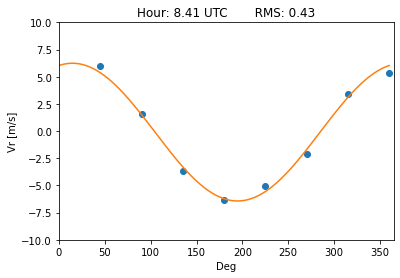

In [12]:
# Picking a random scan
foo = np.where(u_snum[750] == snum)

# Now find the range closest to 500 m
fah = np.where(np.nanmin(np.abs(rng-0.5)) == np.abs(rng-0.5))

deg = np.arange(0,361)

fit = np.sin(np.deg2rad(deg)) * np.cos(np.deg2rad(elevation[0])) * u[750,fah[0]] + \
      np.cos(np.deg2rad(deg)) * np.cos(np.deg2rad(elevation[0])) * v[750,fah[0]] + \
      np.sin(np.deg2rad(elevation[0])) * w[750,fah[0]]


plt.figure()
plt.plot(deg,fit,color='#ff7f0e')
plt.scatter(azimuth[foo],velocity[foo[0],fah[0]])
plt.xlim(0,365)
plt.ylim(-10,10)
plt.ylabel('Vr [m/s]')
plt.xlabel('Deg')
plt.title('Hour: %2.2f UTC       RMS: %2.2f' % (np.nanmean(hour[foo[0]]), residual[750,fah[0]]))
plt.show()

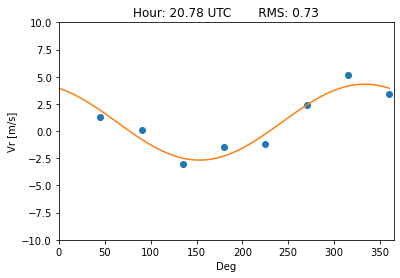

In [13]:
# Picking a random scan
foo = np.where(u_snum[1862] == snum)

# Now find the range closest to 500 m
fah = np.where(np.nanmin(np.abs(rng-0.5)) == np.abs(rng-0.5))

deg = np.arange(0,361)

fit = np.sin(np.deg2rad(deg)) * np.cos(np.deg2rad(elevation[0])) * u[1862,fah[0]] + \
      np.cos(np.deg2rad(deg)) * np.cos(np.deg2rad(elevation[0])) * v[1862,fah[0]] + \
      np.sin(np.deg2rad(elevation[0])) * w[1862,fah[0]]


plt.figure()
plt.plot(deg,fit,color='#ff7f0e')
plt.scatter(azimuth[foo],velocity[foo[0],fah[0]])
plt.xlim(0,365)
plt.ylim(-10,10)
plt.ylabel('Vr [m/s]')
plt.xlabel('Deg')
plt.title('Hour: %2.2f UTC       RMS: %2.2f' % (np.nanmean(hour[foo[0]]), residual[1862,fah[0]]))
plt.show()

As you can see, the RMS values of the daytime fit are slightly higher than the nighttime fit, but both retrivials are pretty good. It is always good to check out the RMS of the retrieval before using the data just to make sure the retrieval is decent.

Now lets display the data! We are going to use some colormaps from the cmocean package. You might need to install the cmocean package for this code to work. For Anaconda this is just
```
conda install -c conda-forge cmocean
```
or with pip
```
pip install cmocean
```

Text(0.5, 1.0, 'Wind Direction')

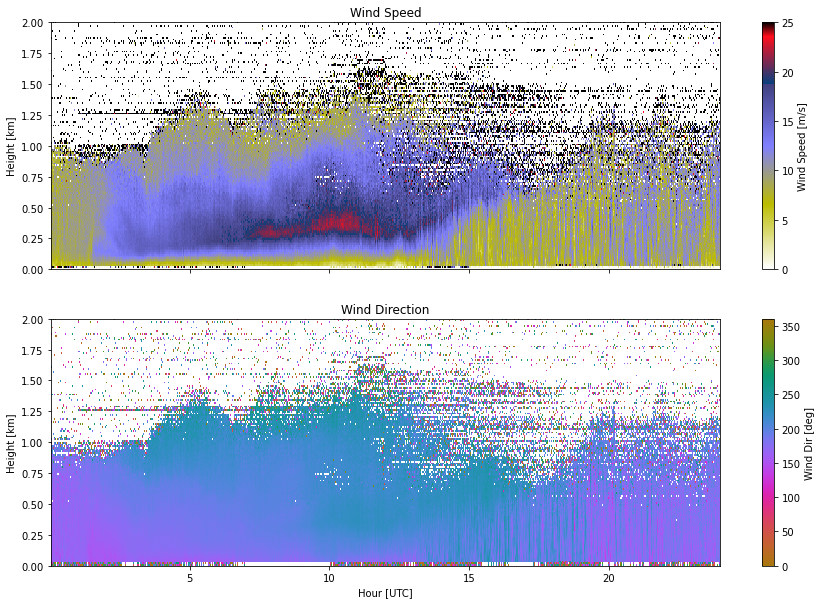

In [14]:
import cmocean

# We need to calculate height from the range values
hgt = np.sin(elevation[0])*rng

fig, (wnd_spd, wnd_dir) =  plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

a = wnd_spd.pcolormesh(time,hgt,speed.T,cmap = 'gist_stern_r', vmin=0, vmax=25, shading = 'auto')
b = wnd_dir.pcolormesh(time,hgt,wdir.T,cmap = cmocean.cm.phase, vmin=0,vmax=360, shading = 'auto')

cb = plt.colorbar(a, ax=wnd_spd)
cb.set_label('Wind Speed [m/s]')

cb = plt.colorbar(b, ax=wnd_dir)
cb.set_label('Wind Dir [deg]')
    
wnd_spd.set_ylim([0,2])
wnd_dir.set_ylim([0,2])

wnd_spd.set_ylabel('Height [km]')
wnd_dir.set_ylabel('Height [km]')
wnd_dir.set_xlabel('Hour [UTC]')

wnd_spd.set_title('Wind Speed')
wnd_dir.set_title('Wind Direction')

Looks like there was a pretty strong LLJ on this night! Notice that the is still bad data when near the top of the lidar's range. This can be mitigated by making the intensity filter a little more stringent. The could, however, get rid of some good data as well. Also notice that the first heights are also bad data. This is due to those gates being in the lidar blind zone. 

You might also want to plot the RMS to get a sense of where the retrievals are good.

Text(0.5, 1.0, 'RMS')

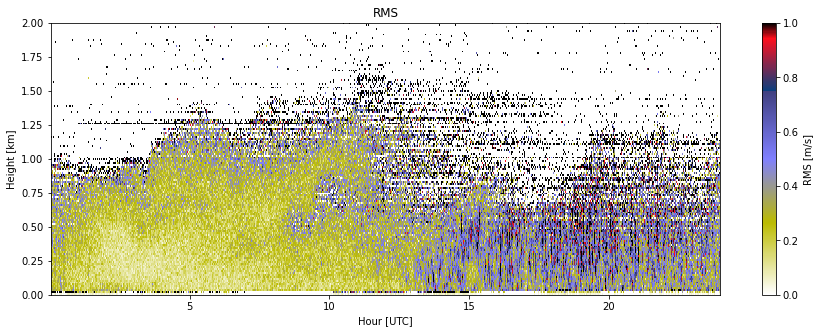

In [15]:
fig, (rms) =  plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

a = rms.pcolormesh(time,hgt,residual.T,cmap = 'gist_stern_r', vmin=0, vmax=1, shading = 'auto')

cb = plt.colorbar(a, ax=rms)
cb.set_label('RMS [m/s]')
 
rms.set_ylim([0,2])

rms.set_ylabel('Height [km]')
rms.set_xlabel('Hour [UTC]')

rms.set_title('RMS')

This clearly shows how the retrivals get worse during the day.

So there you go! You now can process PPI data from CLAMPS! If you have come this far you might be happy to know that 95% of the time you will never have to process your own VADs. The CLAMPS data system shoud do this for you. This processed data can also be found on the THREDDS server. We are going to open one of these processed VAD files and plot a wind profile for this day so you can get familar with the processed VAD files.

First, lets grab the file. This is very similar to what we did previously for the unprocessed PPIs. The only changes to the previous code are to the catalog URL and the file name.

In [16]:
# Catalog for the CLAMPS2 ingested VAD data
catURL = "https://data.nssl.noaa.gov/thredds/catalog/FRDD/CLAMPS/clamps/clamps2/processed/clampsdlvadC2.c1/catalog.xml"

# Open the catalog
cat = TDSCatalog(catURL)

# Date we want to grab
dt = datetime(2021, 6, 20)

# Get the dates for all the netCDF datasets (have to do it this way because file names can be messed up)
nc_dates = []
for ds in cat.datasets:
    if '.cdf' in ds:
        try:
            nc_dates.append(datetime.strptime(ds, "clampsdlvadC2.c1.%Y%m%d.%H%M%S.cdf"))
        except:
            nc_dates.append(datetime(2100,1,1))
            print('This file name is messed up: ' + ds)

nc_dates = np.array(nc_dates)

# Find the index of the date we want
ind = np.argmin(np.abs(dt - nc_dates))

# Get the dataset
ds = cat.datasets[ind]

# Download the dataset we identified to our current working directory
ds.download()

Open the file and print out the variables.

In [17]:
nc = Dataset(ds,'r')

print(nc.variables)

{'height': <class 'netCDF4._netCDF4.Variable'>
float32 height(height)
    long_name: Height
    units: km AGL
unlimited dimensions: 
current shape = (666,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'base_time': <class 'netCDF4._netCDF4.Variable'>
int32 base_time()
    long_name: Time
    units: seconds since 1970-01-01 00:00:00 UTC
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used, 'time_offset': <class 'netCDF4._netCDF4.Variable'>
float64 time_offset(time)
    long_name: Time offset
    units: seconds since base_time
unlimited dimensions: time
current shape = (2150,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'hour': <class 'netCDF4._netCDF4.Variable'>
float64 hour(time)
    long_name: Hour of Day
    units: UTC
unlimited dimensions: time
current shape = (2150,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'wdir': <class 'netCDF4._netCDF4.Variable'>
float32 wdir(time, height)
    long_na

Looks like we want the hour, wspd, wdir, height, and intensity (for filtering) fields

In [18]:
hour = nc.variables['hour'][:]
wspd = nc.variables['wspd'][:]
wdir = nc.variables['wdir'][:]
hgt = nc.variables['height'][:]
intensity = nc.variables['intensity'][:]
nc.close()

Now filter the data with intensity, calculate u and v from the wind speed and wind direction variables and plot a wind profile for a random time.

<ipython-input-19-6f45ef49bc15>:5: RuntimeWarning: invalid value encountered in sin
  u = -wspd*np.sin(np.deg2rad(wdir))
<ipython-input-19-6f45ef49bc15>:6: RuntimeWarning: invalid value encountered in cos
  v = -wspd*np.cos(np.deg2rad(wdir))


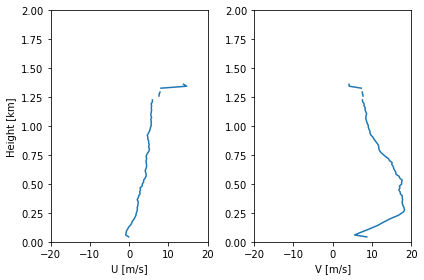

In [19]:
foo = np.where(intensity < 1.006)
wspd[foo] = np.nan
wdir[foo] = np.nan

u = -wspd*np.sin(np.deg2rad(wdir))
v = -wspd*np.cos(np.deg2rad(wdir))

plt.figure()
plt.subplot(1,2,1)
plt.plot(u[600],hgt)
plt.xlim(-20,20)
plt.ylim(0,2)
plt.xlabel('U [m/s]')
plt.ylabel('Height [km]')

plt.subplot(1,2,2)
plt.plot(v[600],hgt)
plt.xlim(-20,20)
plt.ylim(0,2)
plt.xlabel('V [m/s]')

plt.tight_layout()
plt.show()

That wasn't too bad! As an exercise feel free to try to make a time-height plot from the processed VAD file or if you are feeling bold, download data from another day and play around with that. Maybe even try to process PPI files for different day just to get more familar with the process. With over 5 years of CLAMPS data you should be able to find something interesting!

Once you feel comfortable with VADs, check out the tutorials for working with vertical stare data, and RHIs. 

In [20]:
# Use this space to have fun with data!